In [1]:
!pip install \
  "langchain" \
  "langchain-community" \
  "langchain-experimental" \
  "langchain-groq" \
  "langgraph" \
  "openmeteo-requests" \
  "requests-cache" \
  "retry-requests" \
  numpy \
  pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.

In [2]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langgraph.prebuilt import create_react_agent

In [3]:
# --- LLM and Tools Setup ---
groq_api_key = "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"

# Use a capable model for tool usage like Mixtral or Llama3
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="deepseek-r1-distill-llama-70b"
)

In [4]:
TAVILY_API_KEY="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"
tavaily_tool = TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
repl=PythonREPL()

In [5]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code for execution to generate the chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [6]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off."
        " Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [7]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [8]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:

    research_agent = create_react_agent(
    llm,
    tools=[tavaily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
    )

    result = research_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")

    return Command(update={"messages": result["messages"]},goto=goto)

In [9]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:

    chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
    )
    result = chart_agent.invoke(state)

    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")

    return Command(update={"messages": result["messages"]},goto=goto)

In [10]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

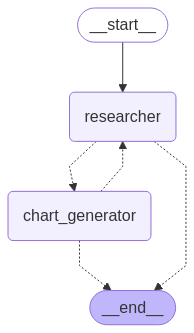

In [11]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

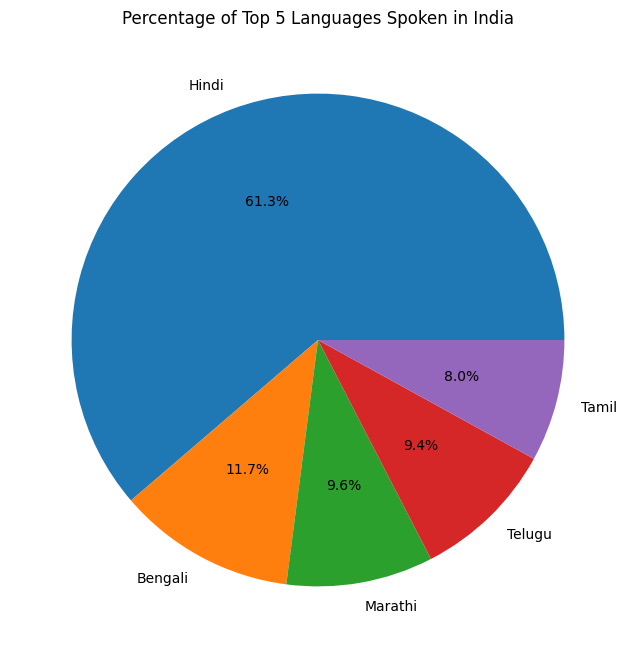

In [13]:
response=app.invoke({"messages":["create a piechart to show percentage of top 5 languages spoken in india.Once you make the chart, finish."]})

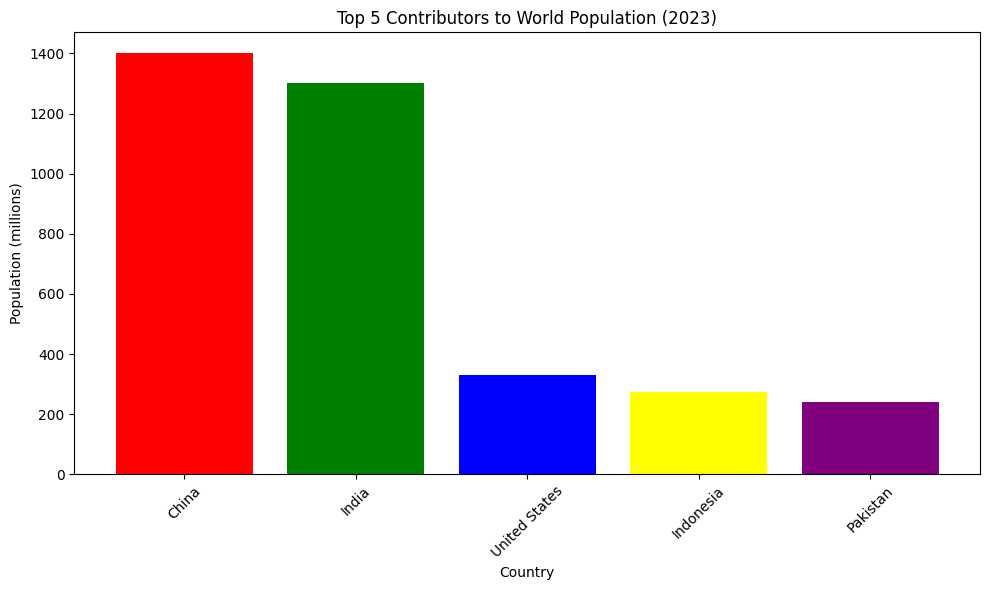

{'messages': [HumanMessage(content='create a bar chart to show top 5 contributers of world population.Once you make the chart, finish.', additional_kwargs={}, response_metadata={}, id='279be43e-a6cd-4b3e-82e6-2a4e0145dcd3'),
  HumanMessage(content='To create a bar chart showing the top 5 contributors to the world population, we first need to gather the most recent population data. As of 2023, the top 5 most populous countries are:\n\n1. China - approximately 1.4 billion\n2. India - approximately 1.3 billion\n3. United States - approximately 331 million\n4. Indonesia - approximately 273 million\n5. Pakistan - approximately 240 million\n\nHere’s how the data can be structured for the chart:\n\n```plaintext\nCountry         Population (millions)\nChina           1,400\nIndia           1,300\nUnited States   331\nIndonesia      273\nPakistan       240\n```\n\nThe chart generator can use this data to create a bar chart with countries on the x-axis and population in millions on the y-axis.',

In [ ]:
app.invoke({"messages":["create a bar chart to show top 5 contributers of world population.Once you make the chart, finish."]})